## This notebook highlight that many parameters in the physics-based model are measured within a certain range (concentration, T, etc.). Extrapolating out of these ranges may produce unphysical results. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pybamm
import pandas as pd

In [2]:
model = pybamm.lithium_ion.DFN()
param = pybamm.ParameterValues("Chen2020")
param.update({"Negative electrode porosity": 0.10})  
exp = pybamm.Experiment([(
    "Hold at 4.2V until C/100", 
    "Discharge at 1.8C until 2.5V (2 seconds period)", 
    "Rest for 1 hours", 
    "Charge at 1C until 4.2V", 
)] )
var_pts = {
    "x_n": 15,  # negative electrode
    "x_s": 15,  # separator 
    "x_p": 15,  # positive electrode
    "r_n": 30,  # negative particle
    "r_p": 20,  # positive particle
}

In [3]:
c_e = model.variables["Electrolyte concentration [mol.m-3]"]
T = model.variables["Cell temperature [K]"]
D_e = param["Electrolyte diffusivity [m2.s-1]"]
sigma_e = param["Electrolyte conductivity [S.m-1]"]
model.variables["Electrolyte diffusivity [m2.s-1]"] = D_e(c_e, T)
model.variables["Electrolyte conductivity [S.m-1]"] = sigma_e(c_e, T)

In [4]:
sim1 = pybamm.Simulation(
    model, 
    experiment=exp,
    parameter_values=param,
    solver=pybamm.CasadiSolver(return_solution_if_failed_early=True),
    var_pts=var_pts,
)
sol1 = sim1.solve(calc_esoh=False)

At t = 152.286 and h = 1.65092e-09, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 141.005 and h = 5.13498e-10, the corrector convergence failed repeatedly or with |h| = hmin.


In [5]:
sol1.cycles[0].steps

In [6]:
# Quick plot
#label = ["Diff_Li_SEI = 1e-18","Diff_Li_SEI = 1e-16"] 
Vars = [
    #"Negative electrode porosity",
    #"Lithium plating thickness [m]",
    'Electrolyte concentration [mol.m-3]',
    "Terminal voltage [V]",
    "Electrolyte conductivity [S.m-1]",
    "Electrolyte diffusivity [m2.s-1]"
]
quick_plot = pybamm.QuickPlot(sol1.cycles[0].steps[1], Vars,variable_limits='fixed') #     
quick_plot.dynamic_plot();

interactive(children=(FloatSlider(value=1288.3151436446217, description='t', max=3154.1918758658585, min=1288.…

##### The nyman electrolyte is from paper: 
A. Nyman, M. Behm, and G. Lindbergh, "Electrochemical characterisation and modelling of the mass transport phenomena in LiPF6-EC-EMC electrolyte,"Electrochim. Acta, vol. 53, no. 22, pp. 6356–6365, 2008.
##### However, in that paper, the electrolyte (LiPF6 in EC:EMC (3:7 wt%)) is only characterized up to 2M. According to 
A. A. Wang, A. B. Gunnarsdottir, J. Fawdon, M. Pasta, C. P. Grey, and C. W. Monroe, "Potentiometric MRI of a Superconcentrated Lithium Electrolyte: Testing the Irreversible Thermodynamics Approach," (in English), Acs Energy Letters, Article vol. 6, no. 9, pp. 3086-3095, Sep 2021, doi: 10.1021/acsenergylett.1c01213. 
##### the LiPF6 in PC will saturated at 3.8M. Therefore, we need to be careful about the results when salt concentration in the electrolyte exceed 2M, and more careful when it exceed 3.8M. 
#### For example, if we look at the initial version of electorlyte properties changing with sal concentration

In [7]:
def electrolyte_diffusivity_Nyman2008(c_e, T):
    D_c_e = 8.794e-11 * (c_e / 1000) ** 2 - 3.972e-10 * (c_e / 1000) + 4.862e-10
    return D_c_e    
def electrolyte_conductivity_Nyman2008(c_e, T):
    sigma_e = (0.1297 * (c_e / 1000) ** 3 - 2.51 * (c_e / 1000) ** 1.5 + 3.329 * (c_e / 1000))
    return sigma_e

def electrolyte_diffusivity_Nyman2008_constant(c_e, T):
    c_e = (c_e<=2000) * c_e + (c_e>2000) *2000
    D_c_e = 8.794e-11 * (c_e / 1000) ** 2 - 3.972e-10 * (c_e / 1000) + 4.862e-10
    return D_c_e    
def electrolyte_conductivity_Nyman2008_constant(c_e, T):
    c_e = (c_e<=2000) * c_e + (c_e>2000) *2000
    sigma_e = (0.1297 * (c_e / 1000) ** 3 - 2.51 * (c_e / 1000) ** 1.5 + 3.329 * (c_e / 1000))
    return sigma_e
c_e = np.linspace(1e-3,5000, 1000)
D_e_initial    = electrolyte_diffusivity_Nyman2008(c_e,25+273.15)
sigma_e_intial = electrolyte_conductivity_Nyman2008(c_e,25+273.15)
D_e_constant    = electrolyte_diffusivity_Nyman2008_constant(c_e,25+273.15)
sigma_e_constant = electrolyte_conductivity_Nyman2008_constant(c_e,25+273.15)

Text(0.5, 1.0, 'Electrolyte conductivity')

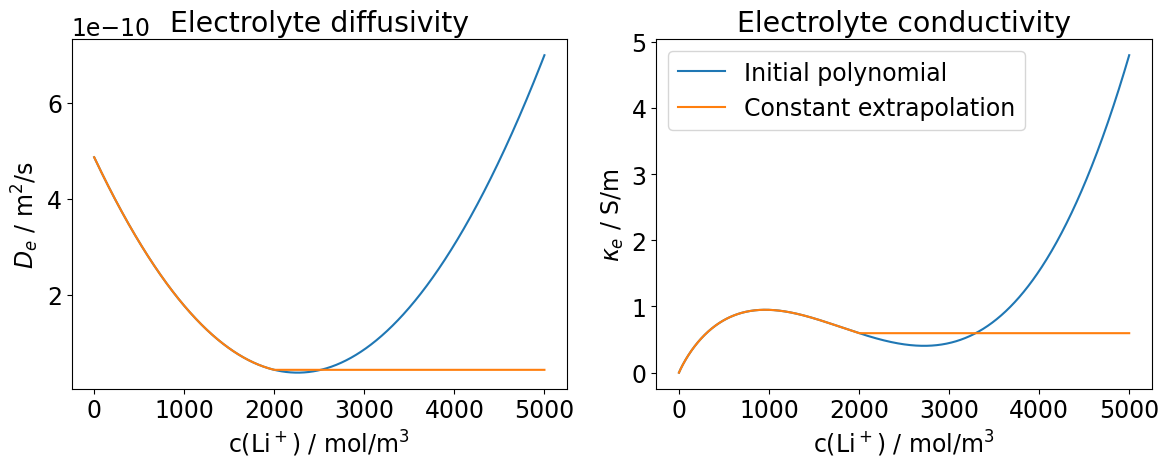

In [8]:
import matplotlib as mpl
dpi=400; fs=17
font = {'family' : 'DejaVu Sans', 'size'   : fs}
mpl.rc('font', **font)
fig, axs = plt.subplots(1,2, figsize=(12,5),tight_layout=True)
axs[0].plot(c_e, D_e_initial,    '-',label=f'Initial polynomial')
axs[0].plot(c_e, D_e_constant,   '-',label=f'Constant extrapolation') 
axs[1].plot(c_e, sigma_e_intial,    '-',label=f'Initial polynomial')
axs[1].plot(c_e, sigma_e_constant,   '-',label=f'Constant extrapolation') 
axs[1].legend(prop={'family':'DejaVu Sans','size':fs},loc='best',)

for j in range(0,2):
    axs[j].set_xlabel(r'c(Li$^+$) / mol/m$^3$') 
axs[0].set_ylabel(r'$D_e$ / m$^2$/s') 
axs[1].set_ylabel(r'$\kappa_e$ / S/m') 
axs[0].set_title("Electrolyte diffusivity",loc='center') 
axs[1].set_title("Electrolyte conductivity",loc='center') 



#### It is clear that by using the initial version of the polynomial fit, the electrolyte diffusivity and conductivity increase abnormally after c(Li+) is larger than 3M, and for conductivity, it goes up to 5 times as the value at 1M, which is unphysical. 

#### We can compare the simulation with constant extrapolation to see the effect on full cell performance

In [9]:
model_2 = pybamm.lithium_ion.DFN()
param_2 = pybamm.ParameterValues("Chen2020")
param_2.update({"Negative electrode porosity": 0.10})  

param_2.update({"Electrolyte diffusivity [m2.s-1]": electrolyte_diffusivity_Nyman2008_constant})  
param_2.update({"Electrolyte conductivity [S.m-1]": electrolyte_conductivity_Nyman2008_constant}) 
c_e = model_2.variables["Electrolyte concentration [mol.m-3]"]
T = model_2.variables["Cell temperature [K]"]
D_e = param_2["Electrolyte diffusivity [m2.s-1]"]
sigma_e = param_2["Electrolyte conductivity [S.m-1]"]
model_2.variables["Electrolyte diffusivity [m2.s-1]"] = D_e(c_e, T)
model_2.variables["Electrolyte conductivity [S.m-1]"] = sigma_e(c_e, T)
sim2 = pybamm.Simulation(
    model_2, 
    experiment=exp,
    parameter_values=param_2,
    solver=pybamm.CasadiSolver(return_solution_if_failed_early=True),
    var_pts=var_pts,
)
sol2 = sim2.solve(calc_esoh=False) 

At t = 486.435 and h = 1.57458e-09, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 187.569 and h = 7.96812e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 179.803 and h = 1.69215e-07, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 32.9987 and h = 2.10746e-07, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 39.6896 and h = 1.69624e-09, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 30.8965 and h = 2.67868e-07, the corrector convergence failed repeatedly or with |h| = hmin.


In [12]:
label = ["Initial polynomial","Constant extrapolation"] 
Vars = [
    'Electrolyte concentration [mol.m-3]',
    "Terminal voltage [V]",
    "Electrolyte conductivity [S.m-1]",
    "Electrolyte diffusivity [m2.s-1]"
]
quick_plot = pybamm.QuickPlot(
    [sol1.cycles[0].steps[1], sol2.cycles[0].steps[1]],
    Vars,label,) #     
quick_plot.dynamic_plot();

interactive(children=(FloatSlider(value=1288.3151436446217, description='t', max=3154.1918758658585, min=1288.…

In [11]:
print(sol1.cycles[0].steps[1]["Time [s]"].entries[-1])
print(sol2.cycles[0].steps[1]["Time [s]"].entries[-1])

3154.1918758658585
1745.8299311130222


### In the above case, using polynomial extrapolation out of measured range give about 100% more discharge capacity at 1.8C compared with constant extrapolation. 